In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import sys

sys.path.append("../../")

In [14]:
# Import all libraries
import pyfortracc
import numpy as np
import xarray as xr

In [15]:
pyfortracc.__version__

'1.0.5rc0'

In [16]:
def avg_intrp(X, d=1):
    """
    Interpolate NaN values in a 2D array using a moving window average.

    Args:
    X (numpy.ndarray): 2D input array with potential NaN values
    d (int): Size of the averaging window (default is 1)

    Returns:
    numpy.ndarray: Array with NaN values interpolated
    """
    # Create a copy of the input array to avoid modifying the original
    X = X.copy()

    # Find indices of NaN values
    bad_idx = np.argwhere(np.isnan(X))

    # Get dimensions of the array
    dim = X.shape

    # Create padded array
    row_pad = np.full((d, dim[1] + (2*d)), np.nan)
    col_pad = np.full((dim[0], d), np.nan)
    pad_X = np.pad(X, ((d, d), (d, d)), mode='constant', constant_values=np.nan)

    # Interpolate NaN values
    for idx in bad_idx:
        row, col = idx
        row_idx = slice(row, row + 2*d + 1)
        col_idx = slice(col, col + 2*d + 1)

        # Extract the window
        window = pad_X[row_idx, col_idx]

        # Calculate mean of non-NaN values
        valid_vals = window[~np.isnan(window)]
        if len(valid_vals) > 0:
            X[row, col] = np.mean(valid_vals)

    # Recursive interpolation if a small percentage of NaNs remain
    nan_ratio = np.sum(np.isnan(X)) / X.size
    if 0 < nan_ratio <= 0.05:
        X = avg_intrp(X, d)

    return X

In [17]:
def read_merg_ir(path):
    """
    Reads MERGIR data from a NetCDF file, extracting brightness temperature data.
    Args:
        path (str): Path to the MERGIR NetCDF file.
    Returns:
        numpy.ndarray: A 2D NumPy array containing the brightness temperature data
                         with dimensions (latitude, longitude). Returns the 'Tb' variable
                         inverted in the latitude dimension.
    """
    MERGIR_data = xr.open_dataset(path)
    brightness_temp = MERGIR_data['Tb'].values
    # Interpolate NaNs
    data_interpolated = avg_intrp(brightness_temp)
    return data_interpolated[::-1]


In [18]:
# Get lat lon from first file
ds = xr.open_dataset("interpolated/202002250000.nc")

# Get the lon_min, lon_max, lat_min and lat_max of the domain
lon_min = float(ds['lon'].min().values)
lon_max = float(ds['lon'].max().values)
lat_min = float(ds['lat'].min().values)
lat_max = float(ds['lat'].max().values)

print(lon_max,lon_min,lat_min,lat_max)

179.9818115234375 -179.9818115234375 -59.981807708740234 59.981807708740234


In [19]:
# Initialize an empty dictionary for the namelist
name_list = {}
name_list['input_path'] = 'interpolated/'
name_list['output_path'] = 'output/'

# Set features name list
name_list['thresholds'] = [235]
name_list['min_cluster_size'] = [150]
name_list['operator'] = '<='
name_list['timestamp_pattern'] = '%Y%m%d%H%M.nc'
name_list['delta_time'] = 30
name_list['cluster_method'] = 'ndimage'
name_list['edges'] = True

# Add correction methods
name_list['spl_correction'] = True # It is used to perform the correction at Splitting events
name_list['mrg_correction'] = True # It is used to perform the correction at Merging events

# Set min overlap percentage
name_list['min_overlap'] = 10

# Spatial parameters
name_list['lon_min'] = lon_min # Set the lon_min
name_list['lon_max'] = lon_max # Set the lon_max
name_list['lat_min'] = lat_min # Set the lat_min
name_list['lat_max'] = lat_max # Set the lat_max

In [37]:
pyfortracc.features_extraction(name_list, read_merg_ir)

Features Extraction:


100%|███████████████████████████████████| 6/6 +                     [Elapsed:00:53 Remaining:<00:00]


In [91]:
pyfortracc.spatial_operations(name_list, read_merg_ir, parallel=False)

Spatial Operations:


 33%|███████████▋                       | 2/6 +                     [Elapsed:00:00 Remaining:<00:01]

Empty DataFrame
Columns: [timestamp, cluster_id, status, past_idx, merge_idx, split_idx]
Index: []


 17%|█████▊                             | 1/6 +                     [Elapsed:06:06 Remaining:<30:30]
 50%|█████████████████▌                 | 3/6 +                     [Elapsed:00:01 Remaining:<00:01]

Empty DataFrame
Columns: [timestamp, cluster_id, status, past_idx, merge_idx, split_idx]
Index: []


 67%|███████████████████████▎           | 4/6 +                     [Elapsed:00:01 Remaining:<00:01]

Empty DataFrame
Columns: [timestamp, cluster_id, status, past_idx, merge_idx, split_idx]
Index: []


 83%|█████████████████████████████▏     | 5/6 +                     [Elapsed:00:02 Remaining:<00:00]

             timestamp  cluster_id   status past_idx     merge_idx  split_idx
60 2020-02-25 02:00:00       719.0  MRG/SPL     77.0  [45, 77, 80]       60.0


100%|███████████████████████████████████| 6/6 +                     [Elapsed:00:03 Remaining:<00:00]

Empty DataFrame
Columns: [timestamp, cluster_id, status, past_idx, merge_idx, split_idx]
Index: []


In [60]:
import pandas as pd

In [73]:
!ls output/track/processing/

features linked   spatial


In [92]:
cur_frm = pd.read_parquet('output/track/processing/spatial/20200225_0200.parquet')
prv_frm = pd.read_parquet('output/track/processing/features/20200225_0130.parquet')
prv_frm.loc[prv_frm.index.isin([77,45,80])]

,timestamp,cluster_id,threshold_level,threshold,size,min,max,mean,std,array_values,array_x,array_y,geometry,file
45,2020-02-25 01:30:00,760,0,235.0,782,227.0,235.0,233.134232,1.644315,"[235.0, 235.0, 235.0, 233.0, 235.0, 233.0, 232...","[3755, 3756, 3754, 3755, 3756, 3753, 3754, 375...","[307, 307, 308, 308, 308, 309, 309, 309, 309, ...",POLYGON ((-43.394967895606484 -48.814788323304...,interpolated/202002250130.nc
77,2020-02-25 01:30:00,1497,0,235.0,410,228.0,235.0,232.293442,1.774407,"[235.0, 232.0, 233.0, 235.0, 234.57143, 232.0,...","[3531, 3530, 3531, 3531, 3531, 3532, 3529, 353...","[541, 542, 542, 543, 544, 544, 545, 545, 545, ...",POLYGON ((-51.54289145689388 -40.3031188243081...,interpolated/202002250130.nc
80,2020-02-25 01:30:00,759,0,235.0,30182,215.0,235.0,227.397354,5.094254,"[235.0, 235.0, 235.0, 235.0, 234.0, 234.0, 235...","[3725, 3726, 3715, 3716, 3717, 3718, 3719, 372...","[307, 307, 308, 308, 308, 308, 308, 308, 308, ...",POLYGON ((-44.4862076582789 -48.81478832330467...,interpolated/202002250130.nc


In [93]:
cur_frm.loc[60]

status                                                       MRG/SPL
threshold_level                                                    0
inside_clusters                                                 None
past_idx                                                        77.0
inside_idx                                                      None
merge_idx                                               [45, 77, 80]
split_pr_idx                                                     NaN
split_cr_idx                                                    None
overlap                                                    90.174234
within                                                          None
contains                                                        None
board                                                          False
board_idx                                                        NaN
u_                                                          2.812868
v_                                

In [59]:
pyfortracc.cluster_linking(name_list)
pyfortracc.concat(name_list, clean=False)

Cluster linking:


100%|███████████████████████████████████| 6/6 +                     [Elapsed:00:00 Remaining:<00:00]

Concatenating:



100%|███████████████████████████████████| 6/6 +                     [Elapsed:00:01 Remaining:<00:00]


In [49]:
# Import duckdb
import duckdb

# Connect to the database
con = duckdb.connect(database=':memory:', read_only=False)

# Open tracking table
tracking_table = con.execute(f"""SELECT * 
                             FROM parquet_scan('output/track/trackingtable/*.parquet',
                             union_by_name=True)
                             """).fetch_df()

In [50]:
# Set lat and lon to zoom
zz_lon_min = -56
zz_lon_max = -39
zz_lat_min = -50
zz_lat_max = -36
zoom_region = [zz_lon_min, zz_lon_max, zz_lat_min, zz_lat_max]

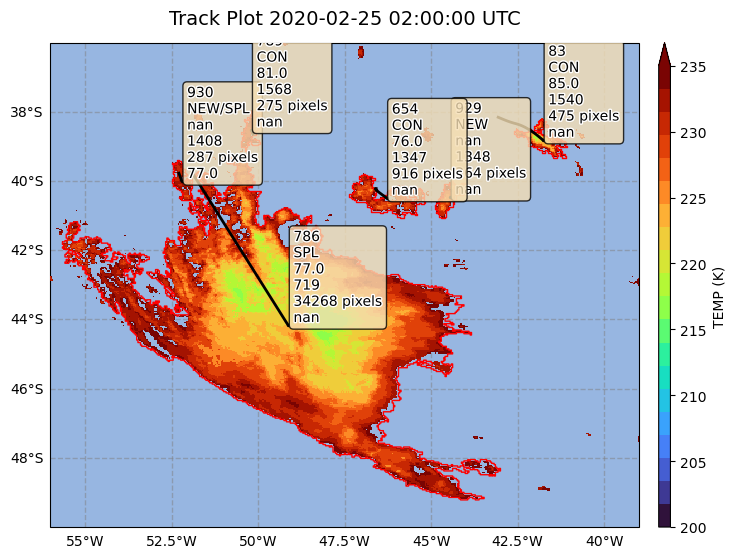

In [51]:
# Plot the tracking data for periods of time. 
pyfortracc.plot(read_function=read_merg_ir, # Read function
    figsize=(8,7), # Figure size
    name_list=name_list, # Name list dictionary
    timestamp ="2020-02-25 02:00:00", # Start timestamp
    info=True,
    info_col_name=False,
    info_cols=['uid','status','past_idx','cluster_id','size','split_pr_idx'],
    cbar_title='TEMP (K)', # Colorbar title
    cmap='turbo', # Colormap
    min_val=200, # Min value
    max_val=235, # Max value
    nan_value=235, # NaN valu
    cbar_extend='max', # Colorbar extend
    nan_operation=np.greater_equal, # NaN operation
    box_fontsize=10, # Box fontsize
    zoom_region=zoom_region
    )

In [ ]:
# Set lat and lon to zoom
zz_lon_min = -56
zz_lon_max = -39
zz_lat_min = -50
zz_lat_max = -36
zoom_region = [zz_lon_min, zz_lon_max, zz_lat_min, zz_lat_max]

In [58]:
# Visualize as animation.
pyfortracc.plot_animation(read_function=read_merg_ir, # Read function
                        figsize=(8,8), # Figure size
                        name_list=name_list, # Name list dictionary
                        start_timestamp = "2020-02-25 01:30:00", # Start timestamp
                        end_timestamp= "2020-02-25 02:00:00", # End timestamp
                        info_col_name=False, # Info column name
                        cbar_title='Temperature(k)', # Colorbar title
                        trajectory=True, # Plot the trajectory
                        smooth_trajectory=True, # Smooth the trajectory
                        cmap='turbo', # Colormap
                        min_val=200, # Min value
                        max_val=235, # Max value
                        nan_value=235, # NaN valu
                        cbar_extend='max', # Colorbar extend
                        nan_operation=np.greater_equal, # NaN operation
                        bound_color='blue', # Bound color
                        info_cols=['uid','cluster_id','status'], # Info columns from tracking table,
                        zoom_region=zoom_region,
                        parallel=True
                        )

Generating animation... 